In [66]:
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_validate
from sklearn import model_selection, preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
import matplotlib.pyplot as plt
import sklearn.model_selection
import sklearn.linear_model
import matplotlib as mlp
import sklearn.metrics
import seaborn as sns
import sklearn
import random
import gc
import os
%matplotlib inline

In [77]:
# Чтение и соединение данных
train_df = pd.read_csv("train.csv", parse_dates=['timestamp'])
macro_df = pd.read_csv("macro.csv", parse_dates=['timestamp'])
df = pd.merge(train_df, macro_df, how='left', on='timestamp')

In [48]:
# Смотрим на минимальные, чтобы не было отрицательных
df.describe().T
# Из таблицы видно, что отрицательных значений нет

,count,mean,std,min,25%,50%,75%,max
full_sq,30471.0,54.214269,38.031487,0.00,38.000000,49.000000,63.000000,5326.0
life_sq,30471.0,34.403271,46.487729,0.00,22.000000,34.403271,38.000000,7478.0
floor,30471.0,7.670803,5.305390,0.00,3.000000,7.000000,11.000000,77.0
max_floor,30471.0,12.558974,5.595529,0.00,9.000000,12.558974,16.000000,117.0
material,30471.0,1.827121,1.226638,1.00,1.000000,1.827121,1.827121,6.0
...,...,...,...,...,...,...,...,...
bandwidth_sports,30471.0,366627.117423,55080.176499,269768.00,329348.000000,398451.000000,398451.000000,463938.0
population_reg_sports_share,30471.0,26.677108,1.906335,22.37,26.677108,26.700000,28.200000,28.2
students_reg_sports_share,30471.0,72.552108,2.958482,64.12,72.552108,72.552108,76.200000,76.2
apartment_build,30471.0,44910.638807,3643.924335,23587.00,44910.638807,46080.000000,46352.000000,46352.0


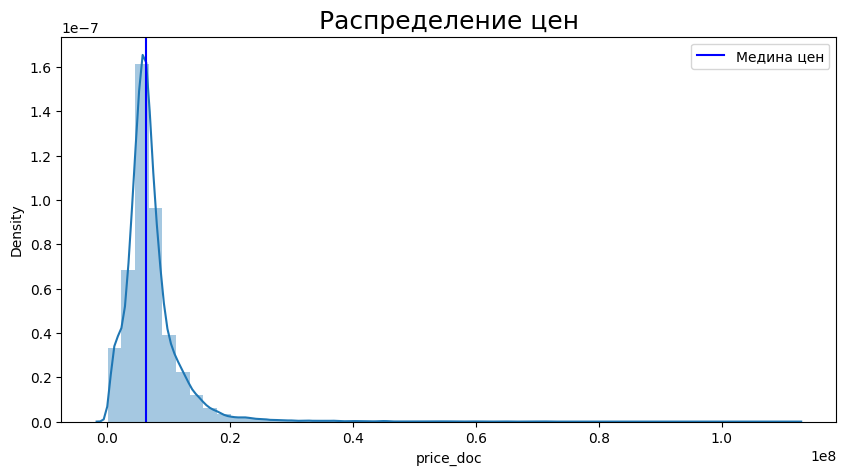

In [ ]:
# Построение график показывающей распределение цен и медиану
fig, ax = plt.subplots(figsize=(10, 5))
sns.distplot(df['price_doc'])
plt.axvline(np.median(df['price_doc']), label='Медина цен', color='blue')
plt.legend()
ax.set_title('Распределение цен', fontsize=18);

In [85]:
df[numeric_columns].corr()['price_doc']

<ipython-input-85-daaebc4fa269>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df[numeric_columns].corr()['price_doc']


id                             0.121203
full_sq                        0.341840
life_sq                        0.151787
floor                          0.117202
max_floor                      0.080182
                                 ...   
bandwidth_sports               0.121824
population_reg_sports_share    0.087251
students_reg_sports_share      0.030419
apartment_build                0.053563
apartment_fund_sqm             0.036461
Name: price_doc, Length: 372, dtype: float64

In [79]:
# Заменяем NaN значения на средние
numeric_columns = df.loc[:,df.dtypes!=np.object].columns
for col in numeric_columns:
    df[col] = df[col].fillna(df[col].mean())

# Формируем выборки
x = df[['full_sq', 'life_sq', 'build_year', 'floor', 'max_floor', 'kitch_sq', 'state', 'num_room', 'kindergarten_km', 'school_km']]
y = df['price_doc']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [88]:
#разделение на тестовую и трнировочную выборку
dfToSave = df[['full_sq', 'life_sq', 'build_year', 'floor', 'max_floor', 'kitch_sq', 'state', 'num_room', 'kindergarten_km', 'school_km', 'price_doc']]

train, test = train_test_split(dfToSave, test_size=0.2, random_state=42)
train.to_csv('trainSave.csv')
test.to_csv('testSave.csv')

Mean Squared Error: 15758306471322.908
R2: 0.26366462629762843
                  Coefficient
full_sq          2.394154e+04
life_sq          5.902141e+03
build_year      -5.523200e-01
floor            7.578587e+04
max_floor        2.616019e+04
kitch_sq         1.740554e+03
state            4.825422e+05
num_room         2.267847e+06
kindergarten_km -1.148721e+05
school_km       -1.286660e+05
b0 -349740.2290684832


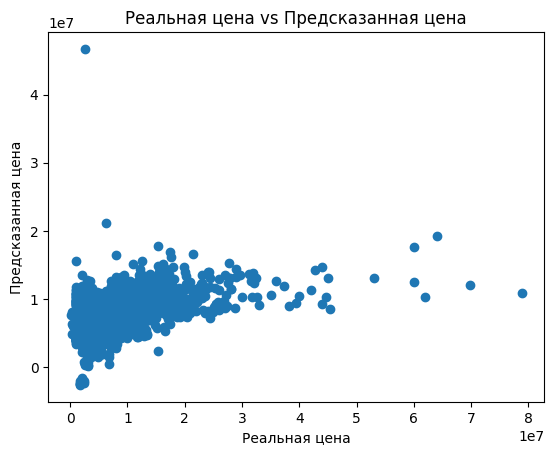

In [89]:
x_train.dropna(inplace=True)
y_train = y_train[x_train.index]

# Построение линейной модели
model = LinearRegression()
model.fit(x_train, y_train)
y_pred = model.predict(x_test)

# Вывод Средней квадратичной ошибки и коефицента детерминации
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

print("R2:", model.score(x_test, y_test))

# Check the coefficients of the model
coef = pd.DataFrame(model.coef_, x.columns, columns=['Coefficient'])
print(coef)
print("b0", model.intercept_)

# Вывод диаграммы
plt.scatter(y_test, y_pred)
plt.xlabel("Реальная цена")
plt.ylabel("Предсказанная цена")
plt.title("Реальная цена vs Предсказанная цена")
plt.show()

In [90]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
import datetime
from sklearn.model_selection import GridSearchCV

now = datetime.datetime.now()

# Load the data
train = pd.read_csv('trainSave.csv')
test = pd.read_csv('testSave.csv')
macro = pd.read_csv('macro.csv')

test.head()



,Unnamed: 0,full_sq,life_sq,build_year,floor,max_floor,kitch_sq,state,num_room,kindergarten_km,school_km,price_doc
0,4739,80,80.0,3068.057097,13.0,12.558974,6.399301,2.107025,1.909804,0.964179,0.470663,12319849
1,26793,44,27.0,1971.000000,7.0,9.000000,6.000000,2.000000,2.000000,0.324766,0.237633,6800000
2,6983,38,20.0,3068.057097,2.0,12.558974,6.399301,2.107025,1.909804,0.098959,0.301669,4650000
3,11307,38,19.0,1976.000000,16.0,16.000000,9.000000,2.000000,1.000000,0.255082,0.182548,1200000
4,20974,34,19.0,1969.000000,1.0,12.000000,9.000000,2.000000,1.000000,0.080566,0.580670,5650000


In [ ]:
import numpy as np
import pandas as pd
from sklearn import preprocessing
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
import datetime
from sklearn.model_selection import GridSearchCV

now = datetime.datetime.now()

train = pd.read_csv('train 2.csv')
test = pd.read_csv('test 2.csv')
macro = pd.read_csv('macro.csv')
id_test = test.id

train.head()

y_train_full = train['price_doc']
x_train_full = train.drop(["id", "timestamp", "price_doc"], axis=1)

x_test = test.drop(["id", "timestamp"], axis=1)

# Текстовые переменные
for c in x_train_full.columns:
    if x_train_full[c].dtype == 'object':
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(x_train_full[c].values))
        x_train_full[c] = lbl.transform(list(x_train_full[c].values))

for c in x_test.columns:
    if x_test[c].dtype == 'object':
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(x_test[c].values))
        x_test[c] = lbl.transform(list(x_test[c].values))

#Гиперпараметры
xgb1 = XGBRegressor()
parameters = {'nthread':[4],
              'objective':['reg:linear'],
              'learning_rate': [.03, 0.05, .07],
              'max_depth': [5, 6, 7],
              'min_child_weight': [4],
              'silent': [1],
              'subsample': [0.7],
              'colsample_bytree': [0.7],
              'n_estimators': [500]}

xgb_grid = GridSearchCV(xgb1,
                        parameters,
                        cv = 2,
                        n_jobs = 5,
                        verbose=True)

xgb_grid.fit(x_train_full,
         y_train_full)

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)


Fitting 2 folds for each of 9 candidates, totalling 18 fits


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:41:56] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:41:56] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:41:57] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:41:57] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


[0]	train-rmse:4704497.73406	test-rmse:4712266.59400
[50]	train-rmse:2340628.55170	test-rmse:2741643.21277
[100]	train-rmse:2068244.28831	test-rmse:2601516.02694
[150]	train-rmse:1945010.03879	test-rmse:2558718.63977
[200]	train-rmse:1853424.44229	test-rmse:2533947.31482
[250]	train-rmse:1777117.92266	test-rmse:2520905.04471
[300]	train-rmse:1707575.46130	test-rmse:2512267.21382
[350]	train-rmse:1644816.59761	test-rmse:2507498.89971
[400]	train-rmse:1593094.59812	test-rmse:2505136.89850
[427]	train-rmse:1565957.44727	test-rmse:2505006.19947


/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:42:54] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [20:42:54] WARNING: /workspace/src/learner.cc:742: 
Parameters: { "silent" } are not used.

  warnings.warn(smsg, UserWarning)


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

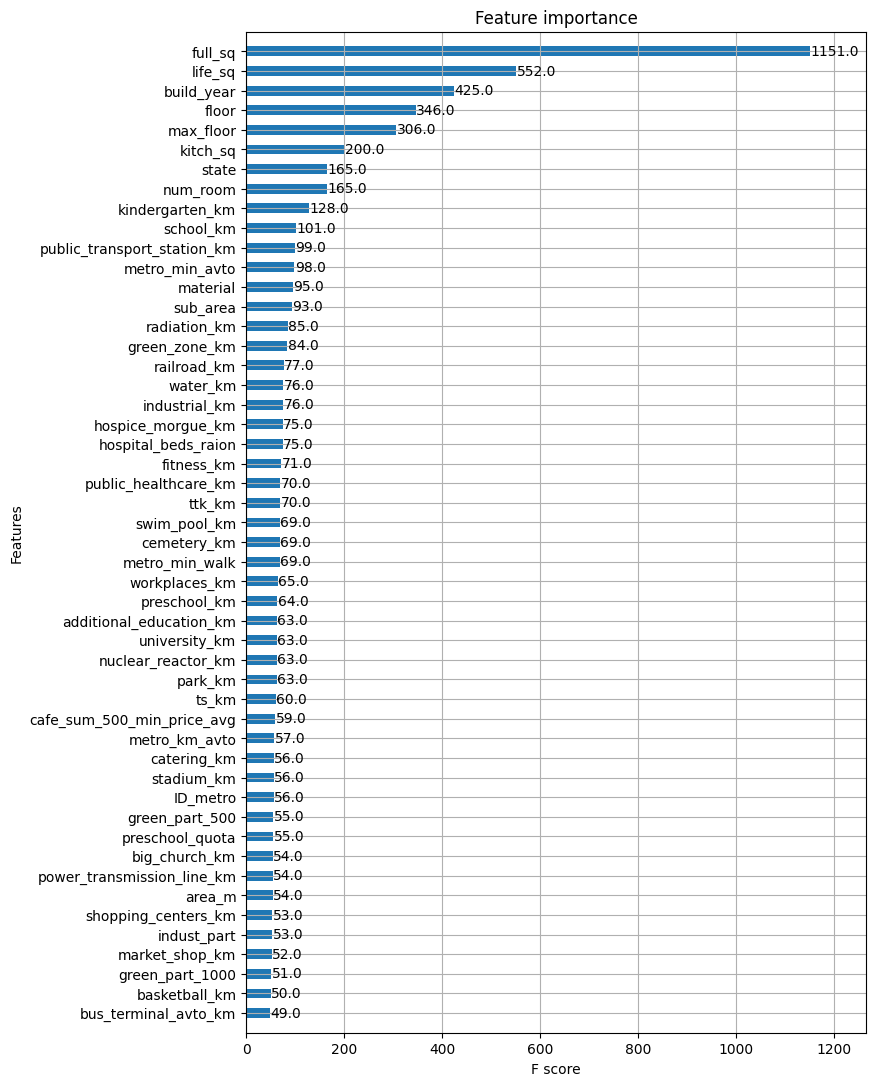

In [95]:
id_test = test.id
train.sample(3)

y_train = train["price_doc"]
x_train = train.drop(["id", "timestamp", "price_doc"], axis=1)
x_test = test.drop(["id", "timestamp"], axis=1)

for c in x_train.columns:
    if x_train[c].dtype == 'object':
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(x_train[c].values))
        x_train[c] = lbl.transform(list(x_train[c].values))

for c in x_test.columns:
    if x_test[c].dtype == 'object':
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(x_test[c].values))
        x_test[c] = lbl.transform(list(x_test[c].values))

xgb_params = {
    'eta': 0.05,
    'max_depth': 5,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
}

dtrain = xgb.DMatrix(x_train, y_train)
dtest = xgb.DMatrix(x_test)

cv_output = xgb.cv(xgb_params, dtrain, num_boost_round=1000, early_stopping_rounds=20,
    verbose_eval=50, show_stdv=False)

num_boost_rounds = len(cv_output)
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round= num_boost_rounds)
fig, ax = plt.subplots(1, 1, figsize=(8, 13))
xgb.plot_importance(model, max_num_features=50, height=0.5, ax=ax)

#Современная Москва

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
import numpy as np

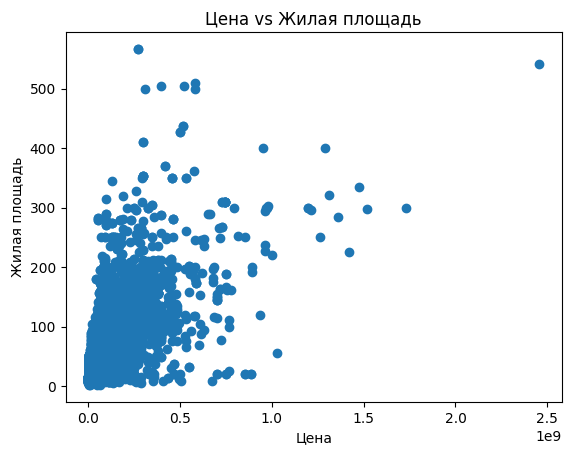

Random Forest Regressor Mean Squared Error: 465215329086816.4
Random Forest Regressor R^2 Score: 0.8350938000073382


In [65]:
ousing_df = pd.read_csv("data.csv")

plt.scatter(housing_df["Price"], housing_df["Living area"])
plt.xlabel("Цена")
plt.ylabel("Жилая площадь")
plt.title("Цена vs Жилая площадь")
plt.show()

numerical_columns = housing_df[['Price','Area', 'Living area', 'Kitchen area', 'Floor', 'Number of rooms', 'Minutes to metro']]
columns = numerical_columns.columns

#Удаляем отклонения используя Z-score
z_threshold = 5
z_scores = stats.zscore(numerical_columns)
#Находим строки где значение Z выходит за установленную границу
outlier_rows = (z_scores > z_threshold).any(axis=1)

#Удаляем отклонения
cleaned_df = numerical_columns[~outlier_rows]
X = cleaned_df.iloc[:,1:]
y = cleaned_df['Price']

#Стандартизируем
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#Случайный лес
random_forest_model = RandomForestRegressor(n_estimators=150, random_state=42)
random_forest_model.fit(X_train, y_train)

RandomForestRegressor(n_estimators=150, random_state=42)
y_pred = random_forest_model.predict(X_test)

#Показания модели
y_pred = random_forest_model.predict(X_test)

#Оценка точности
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Random Forest Regressor Mean Squared Error: {mse}')
print(f'Random Forest Regressor R^2 Score: {r2}')